# Summary

This notebook has four main objectives:

1. First we generate synthetic data using the DGen module
2. Second we use kmeans to determine optimum number of cadres
3. Then we test  results from step 2, using regular Logistic Regression (since the target is binary)
4.  Third, we replicate the SCM from the binaryClassification2.py module 
5. Finally, we also look at how well the classifications perform


In [1]:
# pull from git repositories
!git clone https://github.com/jorje1908/SGMM.git
!git clone https://github.com/newalexander/supervised-cadres.git
!git clone https://github.com/HealthINCITE/cadre.git

Cloning into 'SGMM'...
remote: Enumerating objects: 363, done.
remote: Counting objects: 100% (363/363), done.
remote: Compressing objects: 100% (236/236), done.
remote: Total 363 (delta 232), reused 250 (delta 125), pack-reused 0
Receiving objects: 100% (363/363), 230.93 KiB | 245.00 KiB/s, done.
Resolving deltas: 100% (232/232), done.
Cloning into 'supervised-cadres'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (39/39), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 431 (delta 25), reused 0 (delta 0), pack-reused 392
Receiving objects: 100% (431/431), 321.92 KiB | 440.00 KiB/s, done.
Resolving deltas: 100% (250/250), done.
Cloning into 'cadre'...
remote: Enumerating objects: 215, done.
remote: Counting objects: 100% (215/215), done.
remote: Compressing objects: 100% (149/149), done.
remote: Total 215 (delta 85), reused 142 (delta 35), pack-reused 0
Receiving objects: 100% (215/215), 1.01 MiB | 439.00 KiB/s, done.
Resolving deltas: 100

In [0]:
from  sklearn.datasets import make_regression
import pandas as pd    
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# imports for data generator module
import sys
sys.path.append('cadre/cadre/modules/simulation')
sys.path.append('cadre/cadre/modules/other')
from dgen import DGenerator

# imports for SGMM 
sys.path.append('SGMM/SGMM')
sys.path.append('SGMM/metrics')

# imports for SCM
import sys
from scipy.stats import zscore, zmap
from sklearn.model_selection import train_test_split, KFold
from itertools import product
from joblib import Parallel, delayed
from multiprocessing import cpu_count

# Generate Cadre and Cadre Features

In [0]:
# assign attributes

c_samples = 1000   #Number of samples
c_features = 10     #Number of features
c_informative = 5   #Number of featurs that are informative
c_cadres = 5        #Number of cadres
c_seed = 101        #Randome seed (for repeatability)
c_red = 0           #Number of redundant features (test of multicolinearity impact)
c_classep = 4       #Cadre separation (are there large separations among cadres or are they similar)
c_flip = 0          #Cadre membership flip.  This will flip the membership of x% of cadres

Next, we generate features and cadres based on these features. So these are cadre features. This will help us test the classification modules later on

In [4]:
df_cadre = DGenerator.generate_cadres(samples = c_samples, features = c_features, informative = c_informative, cadres = c_cadres, seed = c_seed, redundant = c_red, classep = c_classep, flip = c_flip)
df_cadre.head()

,cad0,cad1,cad2,cad3,cad4,cad5,cad6,cad7,cad8,cad9,cadre,index_c
0,-4.482410,-4.619843,-0.997349,0.566676,2.126565,1.777562,3.996400,0.529722,5.346935,2.831843,0,0
1,-4.275286,-2.881474,-2.370080,-0.983635,0.938040,0.678835,3.397562,0.145567,3.981830,3.362928,0,1
2,2.775304,-2.224774,-1.369726,-0.906824,-0.686132,0.601892,4.045526,1.985196,3.116355,-3.835390,0,2
3,-3.144241,-3.155927,-0.103750,0.712932,1.052544,0.615533,3.637596,-0.801713,2.217286,4.895699,0,3
4,-1.543432,-4.854725,1.101187,0.297339,-0.196661,-0.038621,3.212342,1.442216,1.648459,6.916369,0,4


In the next cell we generate target and target features. Note that we have separated cadre prediction features from target prediction features.

In [0]:
# assign attributes
t_cadres = 5
t_samples = int(c_samples/t_cadres)
t_features = 5
t_classes = 2
t_informative = 5
t_seed = 101
t_red = 0
t_classep = 6
t_flip = 0

In [6]:
df_variables = DGenerator.generate_variables(cadres = t_cadres, samples = t_samples, features = t_features, classes = t_classes, informative = t_informative, seed = t_seed, redundant = t_red, classep = t_classep, flip = t_flip)
df_variables.head()

,dv0,dv1,dv2,dv3,dv4,target,cadre,index_c
0,5.784785,6.177201,-5.189262,6.070376,-5.898889,1,0,0
1,-7.783252,-5.636362,5.250647,5.624133,-6.060853,0,0,1
2,-6.179748,-5.222403,-4.925779,6.182969,-6.919294,1,0,2
3,7.143124,5.980376,-5.985737,6.742185,-5.723161,1,0,3
4,4.798002,7.331110,-6.460732,6.288602,-5.742962,1,0,4


In [7]:
# merge the two dataframes created
z = pd.merge(df_cadre, df_variables)
z.head()

,cad0,cad1,cad2,cad3,cad4,cad5,cad6,cad7,cad8,cad9,cadre,index_c,dv0,dv1,dv2,dv3,dv4,target
0,-4.482410,-4.619843,-0.997349,0.566676,2.126565,1.777562,3.996400,0.529722,5.346935,2.831843,0,0,5.784785,6.177201,-5.189262,6.070376,-5.898889,1
1,1.477593,-3.269475,-0.234938,-0.763632,-0.596139,0.075753,6.446434,0.518770,5.242586,-4.823776,0,0,5.784785,6.177201,-5.189262,6.070376,-5.898889,1
2,-4.275286,-2.881474,-2.370080,-0.983635,0.938040,0.678835,3.397562,0.145567,3.981830,3.362928,0,1,-7.783252,-5.636362,5.250647,5.624133,-6.060853,0
3,2.775304,-2.224774,-1.369726,-0.906824,-0.686132,0.601892,4.045526,1.985196,3.116355,-3.835390,0,2,-6.179748,-5.222403,-4.925779,6.182969,-6.919294,1
4,-3.144241,-3.155927,-0.103750,0.712932,1.052544,0.615533,3.637596,-0.801713,2.217286,4.895699,0,3,7.143124,5.980376,-5.985737,6.742185,-5.723161,1


In [0]:
df_bin = z.drop(['index_c','cadre','target'], 1)

In [0]:
bcolumns = df_bin.keys()

In [0]:
df_binary = DGenerator.convert_binary(df_bin, bcolumns)

In [11]:
df_binary.head()

,cad0,cad1,cad2,cad3,cad4,cad5,cad6,cad7,cad8,cad9,dv0,dv1,dv2,dv3,dv4
0,0,0,0,1,1,1,1,1,1,1,1,1,0,1,0
1,1,0,0,0,0,1,1,1,1,0,1,1,0,1,0
2,0,0,0,0,1,1,1,1,1,1,0,0,1,1,0
3,1,0,0,0,0,1,1,1,1,0,0,0,0,1,0
4,0,0,0,1,1,1,1,0,1,1,1,1,0,1,0


In [12]:
"""
for downloading dataframes
from google.colab import files

df_easy = z.drop(['index_c'], 1)
df_easy.to_csv('df_easy.csv')
files.download('df_easy.csv')
"""

"\nfor downloading dataframes\nfrom google.colab import files\n\ndf_easy = z.drop(['index_c'], 1)\ndf_easy.to_csv('df_easy.csv')\nfiles.download('df_easy.csv')\n"

# Begin KMeans Clustering

In [0]:
# Prep dataframe for kmeans
from sklearn.cluster import KMeans
df = z.drop(['cadre','index_c', 'target'], 1)

In [0]:
sum_sq = {}
for k in range(1,40):
    kmeans = KMeans(n_clusters = k).fit(df_binary)
    sum_sq[k] = kmeans.inertia_

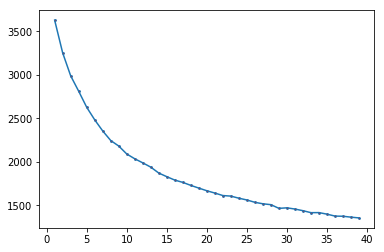

In [15]:
# plot elbow graph
plt.plot(list(sum_sq.keys()),
         list(sum_sq.values()),
        linestyle = '-',
        marker = 'H',
        markersize = 2,
        markerfacecolor = 'red')

From the figure above, we see that the optimum number of clusters goes beyond 30 which could have implications for analysis.

In [16]:
# Append clusters to dataframe
kmeans = KMeans(n_clusters = 10)
kmeans.fit(df_binary)
df_binary["kmeans"] = kmeans.labels_
df_binary.head()

,cad0,cad1,cad2,cad3,cad4,cad5,cad6,cad7,cad8,cad9,dv0,dv1,dv2,dv3,dv4,kmeans
0,0,0,0,1,1,1,1,1,1,1,1,1,0,1,0,8
1,1,0,0,0,0,1,1,1,1,0,1,1,0,1,0,8
2,0,0,0,0,1,1,1,1,1,1,0,0,1,1,0,3
3,1,0,0,0,0,1,1,1,1,0,0,0,0,1,0,7
4,0,0,0,1,1,1,1,0,1,1,1,1,0,1,0,8


In [17]:
df_binary["target"] = z['target']
df_binary.head()

,cad0,cad1,cad2,cad3,cad4,cad5,cad6,cad7,cad8,cad9,dv0,dv1,dv2,dv3,dv4,kmeans,target
0,0,0,0,1,1,1,1,1,1,1,1,1,0,1,0,8,1
1,1,0,0,0,0,1,1,1,1,0,1,1,0,1,0,8,1
2,0,0,0,0,1,1,1,1,1,1,0,0,1,1,0,3,0
3,1,0,0,0,0,1,1,1,1,0,0,0,0,1,0,7,1
4,0,0,0,1,1,1,1,0,1,1,1,1,0,1,0,8,1


In [18]:
# also we need to append kmeans clusters to dataframe z
z["kmeans"] = kmeans.labels_
z.head()

,cad0,cad1,cad2,cad3,cad4,cad5,cad6,cad7,cad8,cad9,cadre,index_c,dv0,dv1,dv2,dv3,dv4,target,kmeans
0,-4.482410,-4.619843,-0.997349,0.566676,2.126565,1.777562,3.996400,0.529722,5.346935,2.831843,0,0,5.784785,6.177201,-5.189262,6.070376,-5.898889,1,8
1,1.477593,-3.269475,-0.234938,-0.763632,-0.596139,0.075753,6.446434,0.518770,5.242586,-4.823776,0,0,5.784785,6.177201,-5.189262,6.070376,-5.898889,1,8
2,-4.275286,-2.881474,-2.370080,-0.983635,0.938040,0.678835,3.397562,0.145567,3.981830,3.362928,0,1,-7.783252,-5.636362,5.250647,5.624133,-6.060853,0,3
3,2.775304,-2.224774,-1.369726,-0.906824,-0.686132,0.601892,4.045526,1.985196,3.116355,-3.835390,0,2,-6.179748,-5.222403,-4.925779,6.182969,-6.919294,1,7
4,-3.144241,-3.155927,-0.103750,0.712932,1.052544,0.615533,3.637596,-0.801713,2.217286,4.895699,0,3,7.143124,5.980376,-5.985737,6.742185,-5.723161,1,8


# Regular Logistic Regression

Now, we test a cadre-based regression to determine the accuracy of the logit regression tool. This will help us compare results with other tools later on

In [19]:
# import Logistic Regression Module
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
lr = LogisticRegression()

#Test Cadre
kmeans = 10
for k in range(kmeans):

    y_cadre = df_binary['target']
    print("regression for cadre ", k)

    # Drop row/observation from dataset if cadre == t
    cadre = df_binary[df_binary.kmeans == k] 

    # Select X features for cadre t
    X_cadre = cadre.drop(['target', 'kmeans'], axis=1) 
    print (X_cadre.shape)
    # Select y features for cadre t
    y_cadre = cadre['target'] 
   

    # Run logistic regression
    X_train, X_test, y_train, y_test = train_test_split(X_cadre, y_cadre, test_size=0.2, random_state=101)
    
    # check to see if target column has only one unique value(ie. 0 and 1)
    if len(y_train.unique()) == 1:
      print ("all one class")
    
    elif len(y_test.unique()) == 1:
      print ("all one class")
    
    # ignore if target column has only one unique value(ie. 0 and 1)
    else:
      fit = lr.fit(X_train, y_train)

      #test accuracy of predictions
      y_train_pred = fit.predict(X_train)
      y_test_pred = fit.predict(X_test)
      
      print("cadre", k, "train", classification_report(y_train, y_train_pred))
      print(classification_report(y_test, y_test_pred))
      print (X_train.shape)

regression for cadre  0
(147, 15)
all one class
regression for cadre  1
(146, 15)
all one class
regression for cadre  2
(50, 15)
cadre 2 train               precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      1.00      1.00        25

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         7

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10

(40, 15)
regression for cadre  3
(60, 15)
cadre 3 train               precision    recall  f1-score   support

           0       1.00      1.00      1.00        32
           1       1.00      1.00     

In the above cell, we find that accuracy is about 100%. This is not surprising because we manipulated the data to give us this result. The "make_classification" module used in the "DGen.py" file helped us to do this. In the next cell, we test the same regression model on the entire dataset irrespective of cadres

In [20]:
data = df_binary.drop(['kmeans'], 1)

X = data.drop(['target'], 1)
y = data['target']

# Run logistic regression
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)
result = lr.fit(X_train, y_train)

pred = result.predict(X_test)

print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.82      0.70      0.76       111
           1       0.69      0.81      0.74        89

    accuracy                           0.75       200
   macro avg       0.75      0.76      0.75       200
weighted avg       0.76      0.75      0.75       200



In the above cell, regression irrespective of cadres gives us an accuracy of about 75%. This is expected because we anticipate the cadre-based regression to perform better.

In [21]:
z.groupby('cadre').describe()

cad0                                          ... kmeans                      
       count      mean       std       min       25%  ...    min   25%  50%   75%  max
cadre                                                 ...                             
0      201.0 -0.031299  4.298202 -7.058527 -4.183709  ...    3.0  3.00  7.0  8.00  9.0
1      201.0  0.130477  4.431900 -7.108085 -4.203660  ...    3.0  6.00  8.0  9.00  9.0
2      200.0 -0.069676  4.194419 -6.521632 -4.208975  ...    2.0  4.25  5.0  5.25  9.0
3      200.0 -4.019848  0.856367 -6.615413 -4.588261  ...    0.0  0.00  1.0  4.00  5.0
4      198.0 -0.081689  4.224734 -6.446648 -4.197512  ...    0.0  1.00  1.0  4.00  6.0

[5 rows x 144 columns]

# Begin SCM

Next, we replicate the work done so far on SCM with help from Alex, Xiao and George's codes

In [0]:
# SCM import
sys.path.append('supervised-cadres/cadreModels')
from classificationBinary import binaryCadreModel
from classificationMulti import multilabelCadreModel

In [0]:
# randomized train-test-split
Dtr, Dva = train_test_split(data, test_size=0.2, random_state=101)

In [0]:
# Identify cadre prediction features from target prediction features (optional)
cadreFts = data.columns[data.columns.str.contains('cad')]
predictFts = data.columns[data.columns.str.contains('dv')]

In [0]:
# merge features
features = cadreFts.union(predictFts)

In [0]:
# standardize training and validation sets
Dva[features] = zmap(Dva[features].values, Dtr[features].values)
Dtr[features] = zscore(Dtr[features].values)

Alex notes:

Define and train SCM model object. We're not going to tune any hyperparameters here. Note that we now supply the binaryCadreModel object with the cadre-assignment features and target-prediction features, as well as the name of the target feature.

If we did not supply any cadreFts or targetFts, they default to being every column in data other than targetCol

In [27]:
# Xiao: just has to tune the parameters.

scm = binaryCadreModel(M=10,lambda_d=0.001,lambda_W=0.001, Tmax=7001, record=500,gamma=1,eta=2e-2)
scm.fit(data=Dtr,
       targetCol='target',
       cadreFts=cadreFts,
       predictFts=predictFts,
       dataVa=Dva,
       progress=True)

W0709 03:39:54.422424 140451748226944 deprecation_wrapper.py:119] From supervised-cadres/cadreModels/classificationBinary.py:114: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0709 03:39:54.470195 140451748226944 deprecation_wrapper.py:119] From supervised-cadres/cadreModels/classificationBinary.py:141: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0709 03:39:54.596567 140451748226944 deprecation_wrapper.py:119] From supervised-cadres/cadreModels/classificationBinary.py:168: The name tf.log is deprecated. Please use tf.math.log instead.

W0709 03:39:54.626926 140451748226944 deprecation_wrapper.py:119] From supervised-cadres/cadreModels/classificationBinary.py:182: The name tf.train.AdamOptimizer is deprecated. Please use tf.compat.v1.train.AdamOptimizer instead.

W0709 03:39:54.706771 140451748226944 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_

numbers being printed: SGD iteration, training loss, training accuracy, validation loss, validation accuracy, time
0
500 0.7255065 0.3875 0.72089124 0.435 1.094135046005249
1000 0.33845192 0.945 0.32913458 0.93 35.06263589859009
training has terminated because: lack of sufficient decrease in validation ROC_AUC


Alex notes:

The metrics attribute of scm contains training and validation metrics values. We can plot them separately. ROC_AUC is the receiver operator characteristic area under the curve (sklearn.metrics.roc_auc_score). PR_AUC is the average precision, i.e., area under the precision-recall curve (sklearn.metrics.average_precision_score).

The x-axis in these plots are dependent on iteration count.

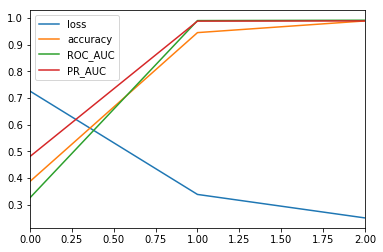

In [28]:
scm.metrics['training'].plot()

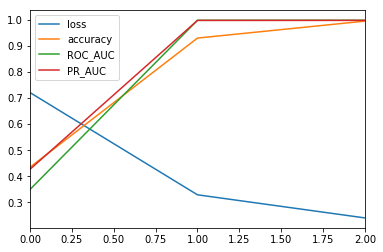

In [29]:
scm.metrics['validation'].plot()

We can use the `predictFull` method for the `binaryCadreModel` class to calculate a variety of quantities on a new dataset. In the below chunk:

- `margin` -- classification margin scores
- `label` -- predicted labels
- `cadre_weight` -- a matrix of cadre membership probabilities
- `cadre` -- predicted cadre memberships
- `loss` -- loss value

In [30]:
scm.scoreMetrics(Dva)

,loss,accuracy,ROC_AUC,PR_AUC
0,0.253037,0.995,0.99838,0.997814


In [31]:
scm.entropy(Dtr)

array([ 0.31797561,  0.04549924, -0.        ,  0.22237923,  1.28485756,
        0.14204216,  0.38271828, -0.        ,  0.09554176,  0.10231049])

In [0]:
f, l, G, m, l = scm.predictFull(Dva)

In [0]:
from itertools import product
from joblib import Parallel, delayed

In [0]:
def scmCrossval(d_tr, d_va, d_te, M, l_W, l_d, cadre_fts, predict_fts, Tmax, record):
    mod = binaryCadreModel(
                Tmax=Tmax, record=record,
                M=M, alpha_d=0.99, alpha_W=0.99, lambda_d=l_d, lambda_W=l_W, gamma=1.)
        
    mod.fit(d_tr, 'target', cadre_fts, predict_fts, d_va, progress=False)
    
    ## evaluate on validation and test sets
    err_va = mod.scoreMetrics(d_va)
    err_te = mod.scoreMetrics(d_te)
    
    ## return everything as a list
    return mod, err_va, err_te

In [0]:
from sklearn.model_selection import KFold

In [0]:
l_ds = np.array([0.01, 0.001])
l_Ws = np.array([0.01, 0.001])
Ms = np.array([4,6,8,10])
n_folds = 10

In [0]:
kf = KFold(n_splits=n_folds, random_state=1414)

n_jobs = np.minimum(12, n_folds * Ms.shape[0] * l_ds.shape[0] * l_Ws.shape[0])

results = (Parallel(n_jobs=n_jobs, backend='threading', verbose=11)(delayed(scmCrossval)
                    (Dtr.iloc[tr], Dtr.iloc[va], Dva, M, l_W, l_d, features, features, 20001, 1000) 
                    for (M, l_d, l_W, (fold, (tr, va))) in product(Ms, l_ds, l_Ws, enumerate(kf.split(Dtr)))))

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed: 220.8min
[Parallel(n_jobs=12)]: Done   2 tasks      | elapsed: 264.9min
[Parallel(n_jobs=12)]: Done   3 tasks      | elapsed: 284.9min
[Parallel(n_jobs=12)]: Done   4 tasks      | elapsed: 322.5min
[Parallel(n_jobs=12)]: Done   5 tasks      | elapsed: 338.1min
[Parallel(n_jobs=12)]: Done   6 tasks      | elapsed: 354.9min
[Parallel(n_jobs=12)]: Done   7 tasks      | elapsed: 380.6min
[Parallel(n_jobs=12)]: Done   8 tasks      | elapsed: 392.6min
[Parallel(n_jobs=12)]: Done   9 tasks      | elapsed: 413.5min
[Parallel(n_jobs=12)]: Done  10 tasks      | elapsed: 413.8min
[Parallel(n_jobs=12)]: Done  11 tasks      | elapsed: 414.0min
[Parallel(n_jobs=12)]: Done  12 tasks      | elapsed: 414.5min
[Parallel(n_jobs=12)]: Done  13 tasks      | elapsed: 414.5min
[Parallel(n_jobs=12)]: Done  14 tasks      | elapsed: 414.7min
[Parallel(n_jobs=12)]: Done  15 task

In [0]:
def extract_scores(results):
    results_va, results_te = [], []
    for model, scores_va, scores_te in results:
        results_va.append(scores_va)
        results_va[-1] = results_va[-1].assign(M=model.M, lambda_d=model.lambda_d, lambda_W=model.lambda_W)
        
        results_te.append(scores_te)
        results_te[-1] = results_te[-1].assign(M=model.M, lambda_d=model.lambda_d, lambda_W=model.lambda_W)
    results_va = pd.concat(results_va).reset_index(drop=True)
    results_te = pd.concat(results_te).reset_index(drop=True)
    print(results_va.head())
    print(results_te.head())
    return results_va, results_te

In [2]:
scores_va, scores_te = extract_scores(results)

NameError: ignored

In [0]:
def get_best_attributes(scores):
    group = scores.groupby(['M','lambda_d','lambda_W'])
    return group.mean().reset_index().sort_values('ROC_AUC', ascending=False).head()

In [0]:
get_best_attributes(scores_va)

In [0]:
def extract_scores(results):
    results_va, results_te = [], []
    for model, scores_va, scores_te in results:
        results_va.append(scores_va)
        results_va[-1] = results_va[-1].assign(M=model.M, lambda_d=model.lambda_d, lambda_W=model.lambda_W)
        
        results_te.append(scores_te)
        results_te[-1] = results_te[-1].assign(M=model.M, lambda_d=model.lambda_d, lambda_W=model.lambda_W)
    results_va = pd.concat(results_va).reset_index(drop=True)
    results_te = pd.concat(results_te).reset_index(drop=True)
    print(results_va.head())
    print(results_te.head())
    return results_va, results_te

In [0]:
scores_va, scores_te = extract_scores(results)

In [0]:
def get_best_attributes(scores):
    group = scores.groupby(['M','lambda_d','lambda_W'])
    return group.mean().reset_index().sort_values('ROC_AUC', ascending=False).head()

In [0]:
get_best_attributes(scores_va)

In [0]:
scm_best = binaryCadreModel(Tmax=20001, record=1000, eps=1e-4, lambda_W=0.001, lambda_d=0.001, M=10, gamma=1.)
scm_best.fit(Dtr, 'target', features, features, Dva, progress=True)

In [0]:
scm.scoreMetrics(Dva)

In [0]:
scm_best.scoreMetrics(Dva)

In [0]:
from sklearn.metrics import roc_auc_score, average_precision_score

In [0]:
def precision_metrics(data, model, data_name, M):
    F, L, __, M, __ = model.predictFull(data)
    temp = pd.DataFrame({'f': np.squeeze(F), 'm': np.squeeze(M), 'l': np.squeeze(L), 'y': data['target'].values})
    scores = {'size': [], 'm': [], 'dataset': [], 'accuracy': [], 'ROC_AUC': [], 'PR_AUC': [], 'proportion': []}
    for m in np.unique(M):
        temp_m = temp.loc[temp['m']==m,:]
        if temp_m.shape[0] < 5: continue
        scores['size'].append(temp_m.shape[0])
        scores['m'].append(m)
        scores['dataset'].append(data_name)
        scores['proportion'].append(temp_m['y'].mean())
        scores['accuracy'].append(np.mean(temp_m['l'] == temp_m['y']))
        scores['ROC_AUC'].append(roc_auc_score(temp_m['y'], temp_m['f']))
        scores['PR_AUC'].append(average_precision_score(temp_m['y'], temp_m['f']))
    return pd.DataFrame(scores)[['dataset', 'm', 'size', 'proportion', 'accuracy', 'ROC_AUC', 'PR_AUC']]

In [0]:
precision_metrics(Dva, scm_best, 'synthetic', 6)

In [0]:
#pd.Series(m).value_counts()

In [0]:
#margin, label, cadre_weight, cadre, loss = scm.predictFull(Dva)

# Begin SGMM

In this section, we use the SGMM to perform a logistic regression focusing on cadre-based accuracy.

In [0]:
# SGMM import
#sys.path.insert(0, '../notebooks')
print(sys.path)
from supervisedGmm import SupervisedGMM
from metricsFunctions import calc_metrics, CalculateSoftLogReg, optimalTau,metrics_cluster
from loaders2 import loader
from mlModels import logisticRegressionCv2, neural_nets, randomforests,\
kmeansLogRegr, xboost, gradboost
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

In [0]:
data1 = data.sample(frac=1,random_state=1512)

In [0]:
columns = ['cluster', 'size', 'target_1','target_0', 
                       'TP', 'TN', 'FP', 'FN', 
                       'FPR', 'specificity', 'sensitivity', 'precision',
                       'accuracy', 'balanced accuracy', 'f1', 'auc']
features = list(data1.iloc[:,:-1])

In [0]:
np.random.seed( seed = 0)
n_clusters = 10
alpha = [0.1, 0.2, 0.5, 1,5]
model = SupervisedGMM( cv=10, alpha = alpha, n_clusters = n_clusters, max_iter = 50, max_iter2 = 5, adaR=1, transduction = 0)
Xtrain, Xtest, ytrain, ytest = model.split( data = data1.values)
model = model.fit( Xtrain = Xtrain, Xtest = [], ytrain = ytrain, simple = 0, kmeans = 1, mod = 1)

In [0]:
mTest, mTrain = model.mTest, model.mTrain
logisRegre = model.LogRegr
fitP = model.fitParams
labTrain, labTest = fitP['labTrain'], fitP['labTest']

probTest, probTrain = model.predict_prob_int( Xtest = Xtest, Xtrain = Xtrain )
tau = optimalTau(probTrain, ytrain)
metTest,_ = calc_metrics(custom_prob = probTest.copy(), tau = tau, y = ytest)
metTrain ,_= calc_metrics(custom_prob = probTrain.copy(), tau = tau, y = ytrain)
metTestSGMM = pd.DataFrame( [metTest], columns = columns)
metTrainSGMM = pd.DataFrame( [metTrain], columns = columns)
print(metTestSGMM, metTrainSGMM)
print()

For the training set above, we find that accuracy is about 100% for all cadres. Similar to results from the SCM section

# Logit Reg with Additional Classification Models


Note:
high_cost represents "target == 1" and
low_cost represents "target == 0"

In [0]:
Cs = [1,10,100,1000]
#FITTING L1 LOGISTIC REGRESSION
pL1, probTestL1, probTrainL1 = logisticRegressionCv2( Xtrain = Xtrain,
                                                  ytrain = ytrain,
                                                  Xtest = Xtest,
                                                  ytest = ytest, Cs = Cs )
tau = optimalTau(probTrainL1, ytrain)

metTest,_ = calc_metrics(custom_prob = probTestL1.copy(), tau = tau, y = ytest)
metTrain ,_= calc_metrics(custom_prob = probTrainL1.copy(), tau = tau, y = ytrain)
metTestL1 = pd.DataFrame( [metTest], columns = columns)
metTrainL1 = pd.DataFrame( [metTrain], columns = columns)

In [0]:
#Fitting Neural Nets
pNN, probTestNN, probTrainNN = neural_nets( Xtrain = Xtrain,
                                                  ytrain = ytrain,
                                                  Xtest = Xtest,
                                                  ytest = ytest,
                                                  h_l_s = (4 ,4, 2))
tau = optimalTau(probTrainNN, ytrain)

metTest,_ = calc_metrics(custom_prob = probTestNN.copy(), tau = tau, y = ytest)
metTrain ,_= calc_metrics(custom_prob = probTrainNN.copy(), tau = tau, y = ytrain)
metTestNN = pd.DataFrame( [metTest], columns = columns)
metTrainNN = pd.DataFrame( [metTrain], columns = columns)

In [0]:
#RANDOM FORESTS
params, probTest, probTrain = randomforests(Xtrain = Xtrain, ytrain = ytrain,
                                            Xtest = Xtest, ytest = ytest)

tau = optimalTau(probTrain, ytrain)
metTest,_ = calc_metrics(custom_prob = probTest.copy(), tau = tau, y = ytest)
metTrain ,_= calc_metrics(custom_prob = probTrain.copy(), tau = tau, y = ytrain)

#PANDA MATRICES
metTestRF = pd.DataFrame( [metTest], columns = columns)
metTrainRF = pd.DataFrame( [metTrain], columns = columns)

In [0]:
#Ada boost
params, probTest, probTrain = xboost(Xtrain = Xtrain, ytrain = ytrain,
                                            Xtest = Xtest, ytest = ytest)

tau = optimalTau(probTrain, ytrain)
metTest,_ = calc_metrics(custom_prob = probTest.copy(), tau = tau, y = ytest)
metTrain ,_= calc_metrics(custom_prob = probTrain.copy(), tau = tau, y = ytrain)

#PANDA MATRICES
metTestXB = pd.DataFrame( [metTest], columns = columns)
metTrainXB = pd.DataFrame( [metTrain], columns = columns)

In [0]:
#Grad boost
params, probTest, probTrain = gradboost(Xtrain = Xtrain, ytrain = ytrain,
                                            Xtest = Xtest, ytest = ytest)

tau = optimalTau(probTrain, ytrain)
metTest,_ = calc_metrics(custom_prob = probTest.copy(), tau = tau, y = ytest)
metTrain ,_= calc_metrics(custom_prob = probTrain.copy(), tau = tau, y = ytrain)

#PANDA MATRICES
metTestGB = pd.DataFrame( [metTest], columns = columns)
metTrainGB = pd.DataFrame( [metTrain], columns = columns)

In [0]:
trainmet = pd.concat([metTrainL1,metTrainSGMM,metTrainRF,metTrainNN,metTrainXB,metTrainGB],ignore_index=True)
testmet = pd.concat([metTestL1,metTestSGMM,metTestRF,metTestNN,metTestXB,metTestGB],ignore_index=True)

In [0]:
method = ['L1 Reg','SGMM','RF','NN','AdaBoost','GradBoost']
trainmet.insert(8,'method',method)
testmet.insert(8,'method',method)

In [0]:
trainmet.iloc[:,8:].round(2)

In [0]:
testmet.iloc[:,8:].round(2)

In [0]:
scm.scoreMetrics(Dva)

Future / Related Tasks:
We made the clusters easily identifiable by tuning the make_classification function. 
For our next test dataset, we will make the clusters difficult to identify to help identify which models perform better

In [0]:
!ls